# Importy

In [1]:
import os
import zipfile
import platform
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import shutil
import warnings
import random
import json
from IPython.display import HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")

# Scrollowalny output w notebooku
display(HTML("<style>.output_scroll {height: 300px; overflow: auto;}</style>"))

2025-03-26 09:41:44.251399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 09:41:44.256274: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 09:41:44.269228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742982104.302747    3888 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742982104.319937    3888 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742982104.338109    3888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Informacje o systemie

In [2]:
# Informacje o systemie
print("CPU:", platform.processor())
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Cores (physical/logical):", psutil.cpu_count(logical=False), "/", psutil.cpu_count(logical=True))
print("RAM:", round(psutil.virtual_memory().total / (1024**3), 2), "GB")
print("OS:", platform.system(), platform.release())
print("Python version:", platform.python_version())

CPU: x86_64
GPU available: []
Cores (physical/logical): 2 / 4
RAM: 15.43 GB
OS: Linux 5.10.234-225.910.amzn2.x86_64
Python version: 3.11.11


2025-03-26 09:41:47.403266: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Ścieżki dostępu i parametry

In [3]:
config = {
    "EXTRACT_DIR": "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/data/raw/Plant_leave_diseases_dataset_with_augmentation",
    "OUTPUT_DIR": "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/data/processed/plant_village_balanced",
    "RAW_ZIP_PATH": "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/data/raw/Plant_leaf_diseases_dataset_with_augmentation.zip",
    "TARGET_PER_CLASS": 2000,
    "IMG_SIZE": (224, 224),
    "SEED": 42,
    "TEST_SIZE": 0.2
}

# Rozpakowanie zbioru danych

In [4]:
with zipfile.ZipFile(config["RAW_ZIP_PATH"], 'r') as zip_ref:
    zip_ref.extractall(config["EXTRACT_DIR"])

# Rozkład klas

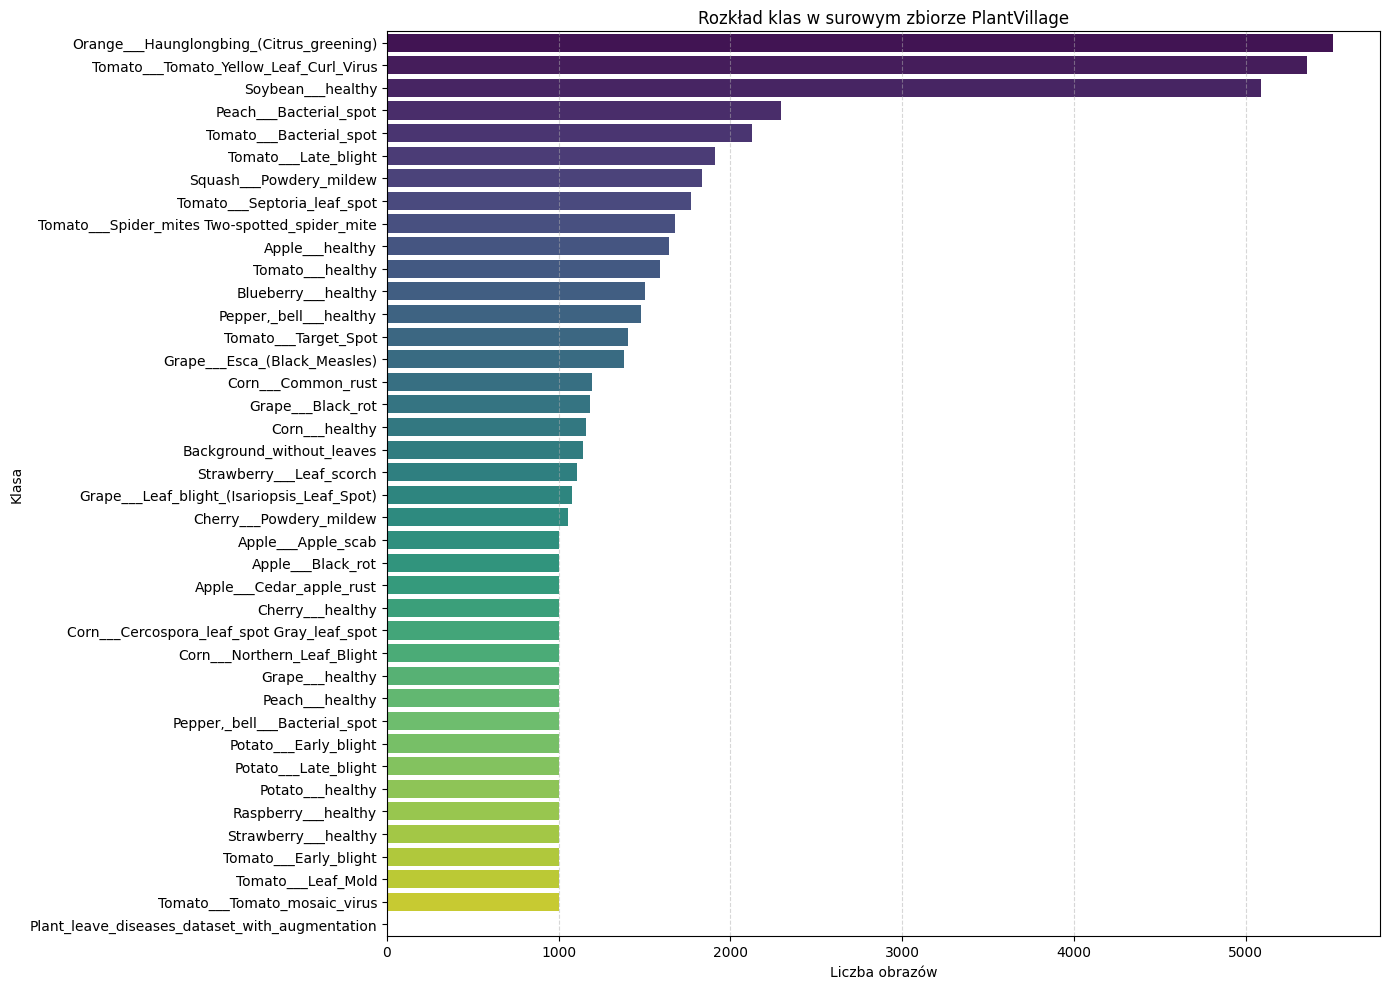

In [5]:
EXTRACT_DIR = config["EXTRACT_DIR"]

root_folders = [f for f in os.listdir(EXTRACT_DIR) if os.path.isdir(os.path.join(EXTRACT_DIR, f))]

# Jeśli istnieje tylko jeden taki folder – zakładamy, że to wrapper (główna paczka ZIP)
if len(root_folders) == 1:
    CLASS_ROOT = os.path.join(EXTRACT_DIR, root_folders[0])
else:
    CLASS_ROOT = EXTRACT_DIR 

class_counts = {}

# Iterujemy po folderach klas
for class_name in sorted(os.listdir(CLASS_ROOT)):
    class_path = os.path.join(CLASS_ROOT, class_name)
    
    if not os.path.isdir(class_path):
        continue

    image_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
           and os.path.isfile(os.path.join(class_path, f))
    ]
    
    class_counts[class_name] = len(image_files)

# Sortujemy malejąco po liczności klas
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Wykres
plt.figure(figsize=(14, 10))
sns.barplot(x=list(sorted_counts.values()), y=list(sorted_counts.keys()), palette='viridis')
plt.title("Rozkład klas w surowym zbiorze PlantVillage")
plt.xlabel("Liczba obrazów")
plt.ylabel("Klasa")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Funkcja augmentująca

In [6]:
def get_augmentor(**kwargs):
    """
    Zwraca generator augmentacji z ustalonymi parametrami.
    """
    return ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Funkcja przetwarzająca zbiór

In [7]:
def process_dataset_with_checkpoints(**kwargs):
    """
    Przetwarza zbiór obrazów klasyfikacyjnych na zbalansowany zestaw treningowy i testowy.

    Dla każdej klasy w katalogu wejściowym:
    - Wczytuje obrazy i skaluje je do zadanego rozmiaru.
    - W razie potrzeby wykonuje augmentację obrazów, aby osiągnąć docelową liczbę przykładów.
    - Losowo miesza obrazy i dzieli je na podzbiory treningowy i testowy.
    - Zapisuje dane do odpowiednich folderów docelowych w formacie JPEG.

    Parametry
    ----------
    EXTRACT_DIR : str
        Ścieżka do katalogu zawierającego dane wejściowe (struktura: podkatalogi per klasa).
    OUTPUT_DIR : str
        Ścieżka do katalogu docelowego, gdzie zapisane zostaną dane przetworzone.
    TARGET_PER_CLASS : int
        Docelowa liczba obrazów na klasę (w zbiorze train + test łącznie).
    IMG_SIZE : tuple of int
        Docelowy rozmiar obrazów (szerokość, wysokość) np. (224, 224).
    SEED : int
        Wartość ziarna losowości dla replikowalności shufflowania i augmentacji.
    TEST_SIZE : float
        Proporcja danych przeznaczonych na zbiór testowy (np. 0.2 dla 80/20 splitu).

    Zapisuje
    --------
    - Pliki JPEG w katalogu OUTPUT_DIR/train/<klasa>/ i OUTPUT_DIR/test/<klasa>/
    - Każda klasa zawiera dokładnie `TARGET_PER_CLASS` przykładów (train + test)
    """

    extract_dir = kwargs["EXTRACT_DIR"]
    output_dir = kwargs["OUTPUT_DIR"]
    target_per_class = kwargs["TARGET_PER_CLASS"]
    img_size = kwargs["IMG_SIZE"]
    seed = kwargs["SEED"]
    test_size = kwargs["TEST_SIZE"]

    checkpoint_path = os.path.join(output_dir, "checkpoint.json")
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "r") as f:
            processed_classes = set(json.load(f))
    else:
        processed_classes = set()

    augmentor = get_augmentor()

    for class_name in sorted(os.listdir(extract_dir)):
        if class_name in processed_classes:
            print(f"⏩ Pomijanie przetworzonej klasy: {class_name}")
            continue

        class_path = os.path.join(extract_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(image_files) == 0:
            continue

        print(f"\nPrzetwarzanie klasy: {class_name} ({len(image_files)} obrazów)")

        if len(image_files) >= target_per_class:
            selected_files = random.sample(image_files, target_per_class)
        else:
            selected_files = image_files.copy()

        images = []
        for fname in selected_files:
            try:
                img_path = os.path.join(class_path, fname)
                img = Image.open(img_path).convert("RGB").resize(img_size)
                images.append(img)
            except Exception:
                continue

        if len(images) < target_per_class:
            needed = target_per_class - len(images)
            print(f"Augmentacja: potrzebnych {needed} obrazów")
            base_array = np.array([np.array(im) for im in images]).astype('float32') / 255.0
            gen = augmentor.flow(base_array, batch_size=1, seed=seed)

            while len(images) < target_per_class:
                aug_img = next(gen)[0]
                images.append(Image.fromarray((aug_img * 255).astype(np.uint8)))

        random.shuffle(images)
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=seed)

        for subset_name, subset in zip(["train", "test"], [train_imgs, test_imgs]):
            class_folder = os.path.join(output_dir, subset_name, class_name)
            os.makedirs(class_folder, exist_ok=True)
            for idx, img in enumerate(subset):
                img.save(os.path.join(class_folder, f"img_{idx:05d}.jpg"), format="JPEG", quality=95)

        # Zapis checkpointa
        processed_classes.add(class_name)
        with open(checkpoint_path, "w") as f:
            json.dump(sorted(processed_classes), f)

    print("\n Wszystkie klasy przetworzone i zapisane.")

In [ ]:
process_dataset_with_checkpoints(**config)


Przetwarzanie klasy: Apple___Apple_scab (1000 obrazów)
Augmentacja: potrzebnych 1000 obrazów

Przetwarzanie klasy: Apple___Black_rot (1000 obrazów)
Augmentacja: potrzebnych 1000 obrazów

Przetwarzanie klasy: Apple___Cedar_apple_rust (1000 obrazów)
Augmentacja: potrzebnych 1000 obrazów

Przetwarzanie klasy: Apple___healthy (1645 obrazów)
Augmentacja: potrzebnych 355 obrazów

Przetwarzanie klasy: Background_without_leaves (1143 obrazów)
Augmentacja: potrzebnych 857 obrazów

Przetwarzanie klasy: Blueberry___healthy (1502 obrazów)
Augmentacja: potrzebnych 498 obrazów

Przetwarzanie klasy: Cherry___Powdery_mildew (1052 obrazów)
Augmentacja: potrzebnych 948 obrazów

Przetwarzanie klasy: Cherry___healthy (1000 obrazów)
Augmentacja: potrzebnych 1000 obrazów

Przetwarzanie klasy: Corn___Cercospora_leaf_spot Gray_leaf_spot (1000 obrazów)
Augmentacja: potrzebnych 1000 obrazów

Przetwarzanie klasy: Corn___Common_rust (1192 obrazów)
Augmentacja: potrzebnych 808 obrazów

Przetwarzanie klasy: Corn__

In [ ]:
#!jupyter nbconvert --to html prepare_balanced_dataset.ipynb